In [63]:
import numpy as np


def get_hop_distance(num_node, edge, max_hop=1):
    # link matrix
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1

    # compute hop steps
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(max_hop + 1)]
    arrive_mat = np.stack(transfer_mat) > 0
    for d in range(max_hop, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis


def normalize_digraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i] ** (-1)
    AD = np.dot(A, Dn)
    return AD


def edge2mat(link, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in link:
        A[j, i] = 1
    return A

def get_spatial_graph(num_node, self_link, inward, outward):
    I = edge2mat(self_link, num_node)
    In = normalize_digraph(edge2mat(inward, num_node))
    Out = normalize_digraph(edge2mat(outward, num_node))
    A = np.stack((I, In, Out))
    return A

class GraphWithPartition:  # Unidirected, connections with hop limit
    """The Graph to model the skeletons 
    Args:
        num_nodes (int): Number of spatial nodes in the graph.
        center (int): Index of the center node.
        inward_edges (list): List of spatial edges connecting the skeleton.
        strategy (string): must be one of the follow candidates
        - uniform: Uniform Labeling
        - distance: Distance Partitioning
        - spatial: Spatial Configuration
        For more information, please refer to the section 'Partition
        Strategies' in the ST-GCN paper (https://arxiv.org/abs/1801.07455).
        
        max_hop (int): the maximal distance between two connected nodes. Default: 1
        dilation (int): controls the spacing between the kernel points. Default: 1
    """

    def __init__(
        self,
        num_nodes,
        center,
        inward_edges,
        strategy="spatial",
        max_hop=1,
        dilation=1,
    ):
        self.num_nodes = num_nodes
        self.center = center
        self.self_edges = [[i, i] for i in range(self.num_nodes)]
        self.inward_edges = inward_edges
        self.edges = self.self_edges + self.inward_edges

        self.max_hop = max_hop
        self.dilation = dilation

        self.hop_dis = get_hop_distance(self.num_nodes, self.edges, max_hop=max_hop)
        self.get_adjacency(strategy)

    def get_adjacency(self, strategy):
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_nodes, self.num_nodes))
        for hop in valid_hop:
            adjacency[self.hop_dis == hop] = 1
        normalize_adjacency = normalize_digraph(adjacency)

        if strategy == "uniform":
            A = np.zeros((1, self.num_nodes, self.num_nodes))
            A[0] = normalize_adjacency
            self.A = A
        elif strategy == "distance":
            A = np.zeros((len(valid_hop), self.num_nodes, self.num_nodes))
            for i, hop in enumerate(valid_hop):
                A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
            self.A = A
        elif strategy == "spatial":
            A = []
            for hop in valid_hop:
                a_root = np.zeros((self.num_nodes, self.num_nodes))
                a_close = np.zeros((self.num_nodes, self.num_nodes))
                a_further = np.zeros((self.num_nodes, self.num_nodes))
                for i in range(self.num_nodes):
                    for j in range(self.num_nodes):
                        if self.hop_dis[j, i] == hop:
                            if (
                                self.hop_dis[j, self.center]
                                == self.hop_dis[i, self.center]
                            ):
                                a_root[j, i] = normalize_adjacency[j, i]
                            elif (
                                self.hop_dis[j, self.center]
                                > self.hop_dis[i, self.center]
                            ):
                                a_close[j, i] = normalize_adjacency[j, i]
                            else:
                                a_further[j, i] = normalize_adjacency[j, i]
                if hop == 0:
                    A.append(a_root)
                else:
                    A.append(a_root + a_close)
                    A.append(a_further)
            A = np.stack(A)
            self.A = A
        else:
            raise ValueError("This Graph construction strategy is not supported")

class SpatialGraph:
    """
    Graph construction with equal weight to all the nodes.
    Args:
        num_nodes (int): Number of spatial nodes in the graph.
        inward_edges (list): List of spatial edges connecting the skeleton.
    """
    def __init__(self, num_nodes, inward_edges, strategy="spatial"):
        self.num_nodes = num_nodes
        self.strategy = strategy
        self.self_edges = [(i, i) for i in range(num_nodes)]
        self.inward_edges = inward_edges
        self.outward_edges = [(j, i) for (i, j) in self.inward_edges]
        self.A = self.get_adjacency_matrix()

    def get_adjacency_matrix(self):
        if self.strategy == "spatial":
            return get_spatial_graph(
                self.num_nodes, self.self_edges, self.inward_edges, self.outward_edges
            )
        else:
            raise ValueError()


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ConvTemporalGraphical(nn.Module):
    """The basic module for applying a graph convolution.
    Args:
        in_channels (int): Number of channels in the input sequence data.
        out_channels (int): Number of channels produced by the convolution.
        kernel_size (int): Size of the graph convolving kernel.
        t_kernel_size (int): Size of the temporal convolving kernel.
        t_stride (int, optional): Stride of the temporal convolution. Default: 1.
        t_padding (int, optional): Temporal zero-padding added to both sides
            of the input. Default: 0.
        t_dilation (int, optional): Spacing between temporal kernel elements.
            Default: 1.
        bias (bool, optional): If ``True``, adds a learnable bias to the
            output. Default: ``True``.
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)`
            format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out}
            , V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)
            ` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]
                `,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        t_kernel_size=1,
        t_stride=1,
        t_padding=0,
        t_dilation=1,
        bias=True,
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * kernel_size,
            kernel_size=(t_kernel_size, 1),
            padding=(t_padding, 0),
            stride=(t_stride, 1),
            dilation=(t_dilation, 1),
            bias=bias,
        )

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc // self.kernel_size, t, v)
        x = torch.einsum("nkctv,kvw->nctw", (x, A))

        return x.contiguous(), A                                                                                


class STGCN_BLOCK(nn.Module):
    """
    Applies a spatial temporal graph convolution over an input graph
    sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data.
        out_channels (int): Number of channels produced by the convolution.
        kernel_size (tuple): Size of the temporal convolving kernel and
            graph convolving kernel.
        stride (int, optional): Stride of the temporal convolution. Default: 1.
        dropout (int, optional): Dropout rate of the final output. Default: 0.
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``.
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)`
            format.
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out},
            V)` format.
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V,
            V)` format.
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, dropout=0, residual=True
    ):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(in_channels, out_channels, kernel_size[1])

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):
        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x), A

class FC(nn.Module):
    """
    Fully connected layer head
    Args:
        n_features (int): Number of features in the input.
        num_class (int): Number of class for classification.
        dropout_ratio (float): Dropout ratio to use. Default: 0.2.
        batch_norm (bool): Whether to use batch norm or not. Default: ``False``.
    """
    def __init__(self, n_features, num_class, dropout_ratio=0.2, batch_norm=False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.bn = batch_norm
        self.n_features = n_features
        if batch_norm:
            self.bn = nn.BatchNorm1d(self.n_features)
            self.bn.weight.data.fill_(1)
            self.bn.bias.data.zero_()
        self.classifier = nn.Linear(n_features, num_class)
        nn.init.normal_(self.classifier.weight, 0, math.sqrt(2.0 / num_class))

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape: (batch_size, n_features)
        
        returns:
            torch.Tensor: logits for classification.
        """

        x = self.dropout(x)
        if self.bn:
            x = self.bn(x)
        x = self.classifier(x)
        return x

class Model(nn.Module):
    """Spatial temporal graph convolutional network backbone
    
    This module is proposed in
    `Spatial Temporal Graph Convolutional Networks for Skeleton-Based Action Recognition
    <https://arxiv.org/pdf/1801.07455.pdf>`_

    Args:
        in_channels (int): Number of channels in the input data.
        graph_args (dict): The arguments for building the graph.
        edge_importance_weighting (bool): If ``True``, adds a learnable importance weighting to the edges of the graph. Default: True.
        n_out_features (int): Output Embedding dimension. Default: 256. 
        kwargs (dict): Other parameters for graph convolution units.
    """
    def __init__(self,
                 in_channels = 2,
                 num_nodes = 29,
                 center = 0,
                 inward_edges = None,
                 edge_importance_weighting = True,
                 n_out_features = 256,
                 n_classes = 1000,
                 dropout_ratio = 0.05,
                 batch_norm=False,) -> None:
        super().__init__()

        self.graph = GraphWithPartition(num_nodes, center, inward_edges)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer("A", A)

        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        self.n_out_features = n_out_features
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        c = in_channels * A.size(1)
        c = c.to(device)
        self.data_bn = nn.BatchNorm1d(c)
        self.st_gcn_networks = nn.ModuleList(
            (
                STGCN_BLOCK(in_channels, 64, kernel_size, 1, residual=False,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 128, kernel_size, 2,),
                STGCN_BLOCK(128, 128, kernel_size, 1,),
                STGCN_BLOCK(128, 128, kernel_size, 1,),
                STGCN_BLOCK(128, 256, kernel_size, 2,),
                STGCN_BLOCK(256, 256, kernel_size, 1,),
                STGCN_BLOCK(256, self.n_out_features, kernel_size, 1,),
            )
        )

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList(
                [nn.Parameter(torch.ones(self.A.size())) for i in self.st_gcn_networks]
            )
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)
        
        self.head = FC(self.n_out_features, n_classes, dropout_ratio, batch_norm)

    def forward(self, x):
        """
        Args: 
            x (torch.Tensor): Input tensor of shape :math:`(N, in\_channels, T_{in}, V_{in})`
        
        Returns:
            torch.Tensor: Output embedding of shape :math:`(N, n\_out\_features)`

        where
            - :math:`N` is a batch size,
            - :math:`T_{in}` is a length of input sequence,
            - :math:`V_{in}` is the number of graph nodes,
            - :math:`n\_out\_features` is the output embedding dimension.

            our input is in shape ntvc
        """
        N, C, T, V = x.size()
        x = x.permute(0, 3, 1, 2).contiguous() # NCTV -> NVCT
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous() # NVCT -> NCTV

        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1)

        return self.head(x)



In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ConvTemporalGraphical(nn.Module):
    """The basic module for applying a graph convolution.
    Args:
        in_channels (int): Number of channels in the input sequence data.
        out_channels (int): Number of channels produced by the convolution.
        kernel_size (int): Size of the graph convolving kernel.
        t_kernel_size (int): Size of the temporal convolving kernel.
        t_stride (int, optional): Stride of the temporal convolution. Default: 1.
        t_padding (int, optional): Temporal zero-padding added to both sides
            of the input. Default: 0.
        t_dilation (int, optional): Spacing between temporal kernel elements.
            Default: 1.
        bias (bool, optional): If ``True``, adds a learnable bias to the
            output. Default: ``True``.
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)`
            format
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out}
            , V)` format
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V, V)
            ` format
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]
                `,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        t_kernel_size=1,
        t_stride=1,
        t_padding=0,
        t_dilation=1,
        bias=True,
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * kernel_size,
            kernel_size=(t_kernel_size, 1),
            padding=(t_padding, 0),
            stride=(t_stride, 1),
            dilation=(t_dilation, 1),
            bias=bias,
        )

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)
        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc // self.kernel_size, t, v)
        x = torch.einsum("nkctv,kvw->nctw", (x, A))

        return x.contiguous(), A                                                                                


class STGCN_BLOCK(nn.Module):
    """
    Applies a spatial temporal graph convolution over an input graph
    sequence.

    Args:
        in_channels (int): Number of channels in the input sequence data.
        out_channels (int): Number of channels produced by the convolution.
        kernel_size (tuple): Size of the temporal convolving kernel and
            graph convolving kernel.
        stride (int, optional): Stride of the temporal convolution. Default: 1.
        dropout (int, optional): Dropout rate of the final output. Default: 0.
        residual (bool, optional): If ``True``, applies a residual mechanism. Default: ``True``.
    Shape:
        - Input[0]: Input graph sequence in :math:`(N, in_channels, T_{in}, V)`
            format.
        - Input[1]: Input graph adjacency matrix in :math:`(K, V, V)` format
        - Output[0]: Output graph sequence in :math:`(N, out_channels, T_{out},
            V)` format.
        - Output[1]: Graph adjacency matrix for output data in :math:`(K, V,
            V)` format.
        where
            :math:`N` is a batch size,
            :math:`K` is the spatial kernel size, as :math:`K == kernel_size[1]`,
            :math:`T_{in}/T_{out}` is a length of input/output sequence,
            :math:`V` is the number of graph nodes.
    """
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, dropout=0, residual=True
    ):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        self.gcn = ConvTemporalGraphical(in_channels, out_channels, kernel_size[1])

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = lambda x: 0

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):
        res = self.residual(x)
        x, A = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x), A

class FC(nn.Module):
    """
    Fully connected layer head
    Args:
        n_features (int): Number of features in the input.
        num_class (int): Number of class for classification.
        dropout_ratio (float): Dropout ratio to use. Default: 0.2.
        batch_norm (bool): Whether to use batch norm or not. Default: ``False``.
    """
    def __init__(self, n_features, num_class, dropout_ratio=0.2, batch_norm=False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_ratio)
        self.bn = batch_norm
        self.n_features = n_features
        if batch_norm:
            self.bn = nn.BatchNorm1d(self.n_features)
            self.bn.weight.data.fill_(1)
            self.bn.bias.data.zero_()
        self.classifier = nn.Linear(n_features, num_class)
        nn.init.normal_(self.classifier.weight, 0, math.sqrt(2.0 / num_class))

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape: (batch_size, n_features)
        
        returns:
            torch.Tensor: logits for classification.
        """

        x = self.dropout(x)
        if self.bn:
            x = self.bn(x)
        x = self.classifier(x)
        return x

class Model(nn.Module):
    """Spatial temporal graph convolutional network backbone
    
    This module is proposed in
    `Spatial Temporal Graph Convolutional Networks for Skeleton-Based Action Recognition
    <https://arxiv.org/pdf/1801.07455.pdf>`_

    Args:
        in_channels (int): Number of channels in the input data.
        graph_args (dict): The arguments for building the graph.
        edge_importance_weighting (bool): If ``True``, adds a learnable importance weighting to the edges of the graph. Default: True.
        n_out_features (int): Output Embedding dimension. Default: 256. 
        kwargs (dict): Other parameters for graph convolution units.
    """
    def __init__(self,
                 in_channels = 2,
                 num_nodes = 29,
                 center = 0,
                 inward_edges = None,
                 edge_importance_weighting = True,
                 n_out_features = 256,
                 n_classes = 1000,
                 dropout_ratio = 0.05,
                 batch_norm=False,) -> None:
        super().__init__()

        self.graph = GraphWithPartition(num_nodes, center, inward_edges)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer("A", A)

        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        self.n_out_features = n_out_features
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))
        self.st_gcn_networks = nn.ModuleList(
            (
                STGCN_BLOCK(in_channels, 64, kernel_size, 1, residual=False,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 64, kernel_size, 1,),
                STGCN_BLOCK(64, 128, kernel_size, 2,),
                STGCN_BLOCK(128, 128, kernel_size, 1,),
                STGCN_BLOCK(128, 128, kernel_size, 1,),
                STGCN_BLOCK(128, 256, kernel_size, 2,),
                STGCN_BLOCK(256, 256, kernel_size, 1,),
                STGCN_BLOCK(256, self.n_out_features, kernel_size, 1,),
            )
        )

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList(
                [nn.Parameter(torch.ones(self.A.size())) for i in self.st_gcn_networks]
            )
        else:
            self.edge_importance = [1] * len(self.st_gcn_networks)
        
        self.head = FC(self.n_out_features, n_classes, dropout_ratio, batch_norm)

    def forward(self, x):
        """
        Args: 
            x (torch.Tensor): Input tensor of shape :math:`(N, in\_channels, T_{in}, V_{in})`
        
        Returns:
            torch.Tensor: Output embedding of shape :math:`(N, n\_out\_features)`

        where
            - :math:`N` is a batch size,
            - :math:`T_{in}` is a length of input sequence,
            - :math:`V_{in}` is the number of graph nodes,
            - :math:`n\_out\_features` is the output embedding dimension.

            our input is in shape ntvc
        """
        N, C, T, V = x.size()
        x = x.permute(0, 3, 1, 2).contiguous() # NCTV -> NVCT
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous() # NVCT -> NCTV

        for gcn, importance in zip(self.st_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * importance)

        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1)

        return self.head(x)



In [66]:
import torch
import torch.nn as nn
import pandas as pd
import os
from torch.utils.data import Dataset
import random
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import math

In [67]:
# DATA_PATH = 'skeleton_dataset/Skeletons/skeleton_data_xys_without_fix_number_frame/' 
DATA_PATH = '/kaggle/input/data-vietnam/skeleton_data_xys_fix50frame/' 
NUM_FRAMES = 30

In [68]:
class VideoDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.videos = []
        self.labels = []
        self.transform = transform
        self.label_encoder = LabelEncoder()
        
        # Duyệt qua tất cả các thư mục con trong thư mục gốc (data_path)
        for folder_name in os.listdir(data_path):
            folder_path = os.path.join(data_path, folder_name)

            # Kiểm tra nếu đây là một thư mục
            if os.path.isdir(folder_path):
                # Duyệt qua tất cả các file CSV trong thư mục con
                for filename in os.listdir(folder_path):
                    if filename.endswith('.csv'):
                        # Đọc từng file CSV, bỏ qua cột đầu tiên (STT)
                        file_path = os.path.join(folder_path, filename)
                        df = pd.read_csv(file_path)

                        # Bỏ qua cột đầu tiên (STT của frame)
                        data = df.iloc[:, 1:].values  # (T, V*3), bỏ cột đầu tiên

                        # Tính toán số khớp (V) từ số cột trong CSV
                        V = data.shape[1] // 3  # Mỗi khớp có 3 giá trị (x, y, z)
                        T = data.shape[0]  # Số khung hình (frames)
                        C = 3  # Số chiều tọa độ (x, y, z)

                        # Reshape dữ liệu từ (T, V*3) -> (T, V, C)
                        video_data = data.reshape(T, V, C)

                        # Thêm video vào danh sách videos
                        self.videos.append(video_data)

                        # Thêm nhãn vào danh sách labels (tên thư mục chứa file)
                        self.labels.append(folder_name)
        # Mã hóa nhãn từ chuỗi thành số nguyên
        self.classes = self.labels
        self.labels = self.label_encoder.fit_transform(self.labels)
        # Tạo tập hợp các cặp (label, class) duy nhất
        unique_pairs = set(zip(self.labels, self.classes))
        
        # Ghi các cặp duy nhất vào file
        with open("class_mapping.txt", "a", encoding="utf-8") as file:
            for label, cls in unique_pairs:
                file.write(f"{label}\t{cls}\n")


    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        label = self.labels[idx]
        

        if self.transform:
            video = self.transform(video)
        
        return video, label


In [69]:
import random
import numpy as np
import torch

class RandomFrameSampler:
    def __init__(self, num_frames):
        self.num_frames = num_frames

    def __call__(self, video):
        """
        Lấy ngẫu nhiên num_frames từ video, trải đều toàn bộ video.
        Nếu số khung hình của video < num_frames, sẽ lặp lại các khung hình.
        Args:
            video: Tensor có kích thước (T, V, C) với T là số khung hình.
        Returns:
            sampled_video: Tensor có kích thước (num_frames, V, C).
        """
        T = video.shape[0]
        
        if T >= self.num_frames:
            # Chia video thành các khoảng đều nhau và chọn một khung hình từ mỗi khoảng
            intervals = np.linspace(0, T, self.num_frames, endpoint=False, dtype=int)
            selected_indices = [random.randint(start, min(start + (T // self.num_frames), T - 1)) for start in intervals]
            sampled_video = video[selected_indices]
        else:
            # Nếu T < num_frames, lặp lại các khung hình để đạt số lượng cần thiết
            sampled_video = video[np.random.choice(T, self.num_frames, replace=True)]
        
        return torch.tensor(sampled_video, dtype=torch.float32)


In [70]:
sampler = RandomFrameSampler(num_frames=30)
dataset = VideoDataset(data_path=DATA_PATH, transform=sampler)

In [71]:
dataset_len = len(dataset)

In [72]:
print(dataset[0][0].shape)

torch.Size([30, 67, 3])


In [73]:
values = []
lable_decode = []
for value, lable in dataset:
    values.append(value.permute(2, 0, 1))
    lable_decode.append(lable)

In [74]:
print(lable_decode)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 21, 21, 21, 21, 21, 21, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

In [75]:
values[0].shape

torch.Size([3, 30, 67])

In [76]:
batch = torch.stack(values, dim=0)

In [77]:
batch.shape

torch.Size([1287, 3, 30, 67])

In [78]:
print(batch[2] == values[2])


tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

In [79]:
batch_x = batch[:, 0]
batch_y = batch[:, 1]
batch_vi = batch[:, -1:]

In [80]:
batch_x.shape
batch_y.shape

torch.Size([1287, 30, 67])

In [81]:
print(batch_x)
print(batch_y)

tensor([[[ 0.0000,  0.0135,  0.0228,  ..., -0.5103, -0.5103, -0.5103],
         [ 0.0000,  0.0152,  0.0254,  ..., -0.5121, -0.5121, -0.5121],
         [ 0.0000,  0.0147,  0.0264,  ..., -0.5157, -0.5157, -0.5157],
         ...,
         [ 0.0000,  0.0156,  0.0267,  ..., -0.5211, -0.5211, -0.5211],
         [ 0.0000,  0.0156,  0.0266,  ..., -0.0908, -0.0896, -0.0895],
         [ 0.0000,  0.0157,  0.0265,  ..., -0.5207, -0.5207, -0.5207]],

        [[ 0.0000,  0.0146,  0.0241,  ..., -0.4864, -0.4864, -0.4864],
         [ 0.0000,  0.0160,  0.0251,  ..., -0.4849, -0.4849, -0.4849],
         [ 0.0000,  0.0176,  0.0259,  ..., -0.4829, -0.4829, -0.4829],
         ...,
         [ 0.0000,  0.0155,  0.0274,  ..., -0.4225, -0.4225, -0.4225],
         [ 0.0000,  0.0153,  0.0272,  ..., -0.0488, -0.0574, -0.0662],
         [ 0.0000,  0.0150,  0.0268,  ..., -0.0371, -0.0452, -0.0524]],

        [[ 0.0000,  0.0118,  0.0191,  ..., -0.5020, -0.5020, -0.5020],
         [ 0.0000,  0.0118,  0.0191,  ..., -0

In [82]:
batch_x_reshape = batch_x.reshape(dataset_len*30, 67)
batch_y_reshape = batch_y.reshape(dataset_len*30, 67)

In [83]:
batch_x_reshape = batch_x_reshape.t()
batch_y_reshape = batch_y_reshape.t()

In [84]:
print(batch_x_reshape)
print(batch_y_reshape)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0135,  0.0152,  0.0147,  ...,  0.0120,  0.0120,  0.0121],
        [ 0.0228,  0.0254,  0.0264,  ...,  0.0221,  0.0221,  0.0227],
        ...,
        [-0.5103, -0.5121, -0.5157,  ..., -0.0673, -0.0673, -0.0749],
        [-0.5103, -0.5121, -0.5157,  ..., -0.0646, -0.0646, -0.0732],
        [-0.5103, -0.5121, -0.5157,  ..., -0.0624, -0.0624, -0.0711]])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0219, -0.0232, -0.0245,  ..., -0.0203, -0.0203, -0.0199],
        [-0.0210, -0.0224, -0.0239,  ..., -0.0196, -0.0196, -0.0192],
        ...,
        [-0.3896, -0.3823, -0.3802,  ...,  0.2036,  0.2036,  0.1825],
        [-0.3896, -0.3823, -0.3802,  ...,  0.2027,  0.2027,  0.1811],
        [-0.3896, -0.3823, -0.3802,  ...,  0.2026,  0.2026,  0.1803]])


In [85]:
batch_x_reshape.shape
batch_y_reshape.shape

torch.Size([67, 38610])

In [86]:
batch_x_reshape.shape

torch.Size([67, 38610])

In [87]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [88]:
# Tạo đối tượng StandardScaler
scaler = StandardScaler()

x_scaled_data = scaler.fit_transform(batch_x_reshape.numpy())
y_scaled_data = scaler.fit_transform(batch_y_reshape.numpy())


In [89]:
import joblib
# Lưu scaler vào file
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [90]:
batch_x = torch.from_numpy(x_scaled_data).t()
batch_y = torch.from_numpy(y_scaled_data).t()

In [91]:
batch_x = batch_x.reshape(-1, 30, 67)
batch_y = batch_y.reshape(-1, 30, 67)

In [92]:
batch_xy = torch.stack([batch_x, batch_y], 1)

In [93]:
batch_xy.shape

torch.Size([1287, 2, 30, 67])

In [94]:
for batch, i in enumerate(batch_xy):
    for coord, j in enumerate(i):
        for frame, k in enumerate(j):
            k = k - k[0]
            batch_xy[batch][coord][frame] = k

batch_xy

tensor([[[[ 0.0000,  0.0514,  0.0867,  ..., -1.9382, -1.9382, -1.9382],
          [ 0.0000,  0.0570,  0.0955,  ..., -1.9254, -1.9254, -1.9254],
          [ 0.0000,  0.0546,  0.0980,  ..., -1.9164, -1.9164, -1.9164],
          ...,
          [ 0.0000,  0.0624,  0.1065,  ..., -2.0799, -2.0799, -2.0799],
          [ 0.0000,  0.2391,  0.4058,  ..., -1.3877, -1.3689, -1.3676],
          [ 0.0000,  0.0626,  0.1060,  ..., -2.0802, -2.0802, -2.0802]],

         [[ 0.0000, -0.0495, -0.0475,  ..., -0.8815, -0.8815, -0.8815],
          [ 0.0000, -0.0519, -0.0502,  ..., -0.8556, -0.8556, -0.8556],
          [ 0.0000, -0.0532, -0.0518,  ..., -0.8257, -0.8257, -0.8257],
          ...,
          [ 0.0000, -0.0797, -0.0793,  ..., -1.2310, -1.2310, -1.2310],
          [ 0.0000, -0.1932, -0.1923,  ...,  2.5338,  2.5636,  2.5723],
          [ 0.0000, -0.0795, -0.0793,  ..., -1.2261, -1.2261, -1.2261]]],


        [[[ 0.0000,  0.0633,  0.1043,  ..., -2.1021, -2.1021, -2.1021],
          [ 0.0000,  0.0690,

In [95]:
batch_xy.shape

torch.Size([1287, 2, 30, 67])

In [96]:
batch_xy[0]

tensor([[[ 0.0000,  0.0514,  0.0867,  ..., -1.9382, -1.9382, -1.9382],
         [ 0.0000,  0.0570,  0.0955,  ..., -1.9254, -1.9254, -1.9254],
         [ 0.0000,  0.0546,  0.0980,  ..., -1.9164, -1.9164, -1.9164],
         ...,
         [ 0.0000,  0.0624,  0.1065,  ..., -2.0799, -2.0799, -2.0799],
         [ 0.0000,  0.2391,  0.4058,  ..., -1.3877, -1.3689, -1.3676],
         [ 0.0000,  0.0626,  0.1060,  ..., -2.0802, -2.0802, -2.0802]],

        [[ 0.0000, -0.0495, -0.0475,  ..., -0.8815, -0.8815, -0.8815],
         [ 0.0000, -0.0519, -0.0502,  ..., -0.8556, -0.8556, -0.8556],
         [ 0.0000, -0.0532, -0.0518,  ..., -0.8257, -0.8257, -0.8257],
         ...,
         [ 0.0000, -0.0797, -0.0793,  ..., -1.2310, -1.2310, -1.2310],
         [ 0.0000, -0.1932, -0.1923,  ...,  2.5338,  2.5636,  2.5723],
         [ 0.0000, -0.0795, -0.0793,  ..., -1.2261, -1.2261, -1.2261]]])

In [97]:
batch_vi.shape

torch.Size([1287, 1, 30, 67])

In [98]:
batch_xy.shape

torch.Size([1287, 2, 30, 67])

In [99]:
batch = torch.cat((batch_xy, batch_vi), dim=1)

In [100]:
torch.save(batch, 'tensor.pt')

In [101]:
batch.shape

torch.Size([1287, 3, 30, 67])

In [102]:
sample = batch[0].unsqueeze(0)
print(sample.shape)
print(sample)

torch.Size([1, 3, 30, 67])
tensor([[[[ 0.0000,  0.0514,  0.0867,  ..., -1.9382, -1.9382, -1.9382],
          [ 0.0000,  0.0570,  0.0955,  ..., -1.9254, -1.9254, -1.9254],
          [ 0.0000,  0.0546,  0.0980,  ..., -1.9164, -1.9164, -1.9164],
          ...,
          [ 0.0000,  0.0624,  0.1065,  ..., -2.0799, -2.0799, -2.0799],
          [ 0.0000,  0.2391,  0.4058,  ..., -1.3877, -1.3689, -1.3676],
          [ 0.0000,  0.0626,  0.1060,  ..., -2.0802, -2.0802, -2.0802]],

         [[ 0.0000, -0.0495, -0.0475,  ..., -0.8815, -0.8815, -0.8815],
          [ 0.0000, -0.0519, -0.0502,  ..., -0.8556, -0.8556, -0.8556],
          [ 0.0000, -0.0532, -0.0518,  ..., -0.8257, -0.8257, -0.8257],
          ...,
          [ 0.0000, -0.0797, -0.0793,  ..., -1.2310, -1.2310, -1.2310],
          [ 0.0000, -0.1932, -0.1923,  ...,  2.5338,  2.5636,  2.5723],
          [ 0.0000, -0.0795, -0.0793,  ..., -1.2261, -1.2261, -1.2261]],

         [[ 0.9985,  0.9964,  0.9963,  ...,  0.0000,  0.0000,  0.0000],
   

In [103]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [104]:
import torch.nn.functional as F

# Danh sách cần one-hot encode
lst = lable_decode

# Tạo từ điển ánh xạ chuỗi sang số nguyên
unique_labels = list(set(lst))  # Lấy các giá trị duy nhất
num_class = len(unique_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Chuyển đổi danh sách chuỗi thành danh sách chỉ số
indices = [label_to_index[label] for label in lst]

# Chuyển danh sách chỉ số thành tensor
tensor_indices = torch.tensor(indices)


In [105]:
num_class

57

In [106]:
len(tensor_indices)

1287

In [107]:
# Kết nối khớp cơ thể (Pose Estimation)
body_connections = [
    (1,4),  
    (0,2),  
    (1,3), 
    (2,7),
    (0,5), 
    (6,4),
    (8,5), 
    (3), 
    (6),
    (10),
    (9),
    (12,13),
    (11,14),
    (11,15),
    (12,16),
    (13,17,21),
    (14,18,22),
    (15,19),
    (16,20),
    (15,17),
    (16,18),
    (15,19),
    (16),
    (24,11),
    (12,23),
    (26),  
    (25, 27),  
    (26, 28),  
    (27, 29),  
    (28),  
    (25, 31, 34),  
    (30, 32),  
    (31, 33),  
    (32),  
    (30, 38), 
    (34, 36),
    (35, 37),
    (36), 
    (34, 42, 39),
    (38, 40),
    (39, 41),
    (40),
    (38, 43),
    (42, 44),
    (43, 45),
    (44),
    (47),  
    (46, 48),  
    (47, 49),  
    (48, 50),  
    (49),  
    (46, 52, 55),  
    (51, 53),  
    (52, 54),  
    (53),  
    (51, 59), 
    (55, 57),
    (56, 58),
    (57), 
    (55, 63, 60),
    (59, 61),
    (60, 62),
    (61),
    (59, 64),
    (63, 65),
    (64, 66),
    (65)
]





In [108]:
len(body_connections)

67

In [109]:
sample = batch[0].unsqueeze(0)
print(sample.shape)
sample

torch.Size([1, 3, 30, 67])


tensor([[[[ 0.0000,  0.0514,  0.0867,  ..., -1.9382, -1.9382, -1.9382],
          [ 0.0000,  0.0570,  0.0955,  ..., -1.9254, -1.9254, -1.9254],
          [ 0.0000,  0.0546,  0.0980,  ..., -1.9164, -1.9164, -1.9164],
          ...,
          [ 0.0000,  0.0624,  0.1065,  ..., -2.0799, -2.0799, -2.0799],
          [ 0.0000,  0.2391,  0.4058,  ..., -1.3877, -1.3689, -1.3676],
          [ 0.0000,  0.0626,  0.1060,  ..., -2.0802, -2.0802, -2.0802]],

         [[ 0.0000, -0.0495, -0.0475,  ..., -0.8815, -0.8815, -0.8815],
          [ 0.0000, -0.0519, -0.0502,  ..., -0.8556, -0.8556, -0.8556],
          [ 0.0000, -0.0532, -0.0518,  ..., -0.8257, -0.8257, -0.8257],
          ...,
          [ 0.0000, -0.0797, -0.0793,  ..., -1.2310, -1.2310, -1.2310],
          [ 0.0000, -0.1932, -0.1923,  ...,  2.5338,  2.5636,  2.5723],
          [ 0.0000, -0.0795, -0.0793,  ..., -1.2261, -1.2261, -1.2261]],

         [[ 0.9985,  0.9964,  0.9963,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9986,  0.9967,  

In [110]:
# Tạo danh sách chi tiết hơn theo dạng (index, value)
detailed_body_connections = [(i, val) for i, conn in enumerate(body_connections) for val in (conn if isinstance(conn, tuple) else (conn,))]

print(detailed_body_connections)

[(0, 1), (0, 4), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 7), (4, 0), (4, 5), (5, 6), (5, 4), (6, 8), (6, 5), (7, 3), (8, 6), (9, 10), (10, 9), (11, 12), (11, 13), (12, 11), (12, 14), (13, 11), (13, 15), (14, 12), (14, 16), (15, 13), (15, 17), (15, 21), (16, 14), (16, 18), (16, 22), (17, 15), (17, 19), (18, 16), (18, 20), (19, 15), (19, 17), (20, 16), (20, 18), (21, 15), (21, 19), (22, 16), (23, 24), (23, 11), (24, 12), (24, 23), (25, 26), (26, 25), (26, 27), (27, 26), (27, 28), (28, 27), (28, 29), (29, 28), (30, 25), (30, 31), (30, 34), (31, 30), (31, 32), (32, 31), (32, 33), (33, 32), (34, 30), (34, 38), (35, 34), (35, 36), (36, 35), (36, 37), (37, 36), (38, 34), (38, 42), (38, 39), (39, 38), (39, 40), (40, 39), (40, 41), (41, 40), (42, 38), (42, 43), (43, 42), (43, 44), (44, 43), (44, 45), (45, 44), (46, 47), (47, 46), (47, 48), (48, 47), (48, 49), (49, 48), (49, 50), (50, 49), (51, 46), (51, 52), (51, 55), (52, 51), (52, 53), (53, 52), (53, 54), (54, 53), (55, 51), (55, 59), (56

In [111]:
detailed_body_connections = [(0, 1), (0, 4), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 7), (4, 0), (4, 5), (5, 6), (5, 4), (6, 8), (6, 5), (7, 3), (8, 6), (9, 10), (10, 9), (11, 12), (11, 13), (12, 11), (12, 14), (13, 11), (13, 15), (14, 12), (14, 16), (15, 13), (15, 17), (15, 21), (16, 14), (16, 18), (16, 22), (17, 15), (17, 19), (18, 16), (18, 20), (19, 15), (19, 17), (20, 16), (20, 18), (21, 15), (21, 19), (22, 16), (23, 24), (23, 11), (24, 12), (24, 23), (25, 26), (26, 25), (26, 27), (27, 26), (27, 28), (28, 27), (28, 29), (29, 28), (30, 25), (30, 31), (30, 34), (31, 30), (31, 32), (32, 31), (32, 33), (33, 32), (34, 30), (34, 38), (35, 34), (35, 36), (36, 35), (36, 37), (37, 36), (38, 34), (38, 42), (38, 39), (39, 38), (39, 40), (40, 39), (40, 41), (41, 40), (42, 38), (42, 43), (43, 42), (43, 44), (44, 43), (44, 45), (45, 44), (46, 47), (47, 46), (47, 48), (48, 47), (48, 49), (49, 48), (49, 50), (50, 49), (51, 46), (51, 52), (51, 55), (52, 51), (52, 53), (53, 52), (53, 54), (54, 53), (55, 51), (55, 59), (56, 55), (56, 57), (57, 56), (57, 58), (58, 57), (59, 55), (59, 63), (59, 60), (60, 59), (60, 61), (61, 60), (61, 62), (62, 61), (63, 59), (63, 64), (64, 63), (64, 65), (65, 64), (65, 66), (66, 65)]

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [113]:
device

device(type='cuda')

In [129]:
model = Model(in_channels=3, num_nodes=67, inward_edges=detailed_body_connections, n_classes=num_class, dropout_ratio = 0.1,batch_norm=True).to(device)

In [115]:
import torch
import torch.nn as nn

In [116]:
len(tensor_indices)

1287

In [117]:
tensor_indices

tensor([10, 10, 10,  ...,  7,  7,  7])

In [118]:
tensor_indices.shape

torch.Size([1287])

In [119]:
from torch.utils.data import random_split
batch_size=50
num_epochs = 50
train_ratio = 0.8
lr=0.01
weight_decay=1e-2
num = len(tensor_indices)
stacked_tensor = torch.stack(values)
train_size = int(train_ratio * num)
val_size = num - train_size
dataset = TensorDataset(stacked_tensor, tensor_indices)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [120]:
# Lấy kích thước từ phần tử đầu tiên trong Subset
train_data_shape = train_dataset[0][0].shape  # Dữ liệu
train_labels_shape = train_dataset[0][1].shape  # Nhãn (1D nên không có .shape thực sự)

print(f"Train data shape: {train_data_shape}")
print(f"Train labels shape: {train_labels_shape}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train data shape: torch.Size([3, 30, 67])
Train labels shape: torch.Size([])
Train dataset size: 1029
Validation dataset size: 258


In [121]:
print(batch.shape)
print(tensor_indices.shape)

torch.Size([1287, 3, 30, 67])
torch.Size([1287])


In [139]:
from thop import profile
flops, params = profile(model, inputs=(train_dataset[0][0].unsqueeze(0).to(device),))
print(f"FLOPS: {flops/1000000000} GFlops")
print(f"Parameters: {params}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 4.521603952 GFlops
Parameters: 3080075.0


In [134]:
!pip install thop

Epoch [1/10] - Train Loss: 1.5276, Val Loss: 2.8151, Train Acc: 0.5734, Val Acc: 0.3605, Train F1: 0.5678, Val F1: 0.3330
Epoch [2/10] - Train Loss: 1.2951, Val Loss: 1.4910, Train Acc: 0.6200, Val Acc: 0.5930, Train F1: 0.6163, Val F1: 0.5674
Epoch [3/10] - Train Loss: 1.0940, Val Loss: 1.7966, Train Acc: 0.6764, Val Acc: 0.5814, Train F1: 0.6720, Val F1: 0.5628
Epoch [4/10] - Train Loss: 0.9506, Val Loss: 2.1190, Train Acc: 0.7075, Val Acc: 0.5620, Train F1: 0.7067, Val F1: 0.5606
Epoch [5/10] - Train Loss: 0.7901, Val Loss: 1.5583, Train Acc: 0.7687, Val Acc: 0.6318, Train F1: 0.7655, Val F1: 0.6078
Epoch [6/10] - Train Loss: 0.6633, Val Loss: 1.9324, Train Acc: 0.7911, Val Acc: 0.6047, Train F1: 0.7894, Val F1: 0.6058
Epoch [7/10] - Train Loss: 0.5887, Val Loss: 1.4041, Train Acc: 0.8183, Val Acc: 0.6202, Train F1: 0.8171, Val F1: 0.6134
Epoch [8/10] - Train Loss: 0.6284, Val Loss: 1.9252, Train Acc: 0.8017, Val Acc: 0.5465, Train F1: 0.8008, Val F1: 0.5394
Epoch [9/10] - Train Los

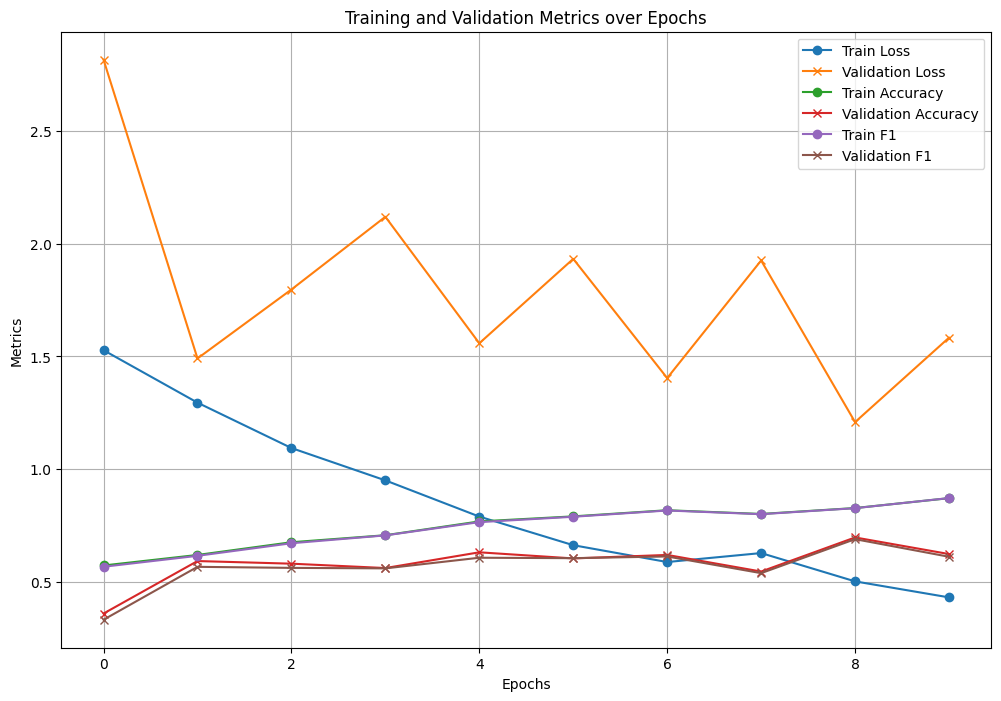

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)
num_epochs = 10
criterion = nn.CrossEntropyLoss()
i = 0
history = {"loss": [], "accuracy": [], "precision": [], "recall": [], "f1": []}
model.train()
# Lưu trữ các giá trị metric theo từng epoch
history = {
    "train_loss": [], "val_loss": [],
    "train_accuracy": [], "val_accuracy": [],
    "train_precision": [], "val_precision": [],
    "train_recall": [], "val_recall": [],
    "train_f1": [], "val_f1": []
}

for epoch in range(num_epochs):
    # Huấn luyện
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass và cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Cộng dồn loss
        running_loss += loss.item()

        # Lưu trữ nhãn thực và dự đoán
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Tính loss và các metric trên tập huấn luyện
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Lưu thông tin vào history
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["train_precision"].append(train_precision)
    history["train_recall"].append(train_recall)
    history["train_f1"].append(train_f1)

    # Đánh giá trên tập validation
    model.eval()
    val_running_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_data in val_dataset:  # Duyệt qua từng mẫu trong tập validation
            val_inputs, val_labels_batch = val_data
            val_inputs, val_labels_batch = val_inputs.to(device), val_labels_batch.to(device)

            # Forward pass
            val_outputs = model(val_inputs.unsqueeze(0))  # Thêm batch dimension cho 1 mẫu
            val_loss = criterion(val_outputs, val_labels_batch.unsqueeze(0))
            val_running_loss += val_loss.item()

            # Lưu nhãn thực và dự đoán
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.append(val_labels_batch.cpu().item())
            val_preds.append(val_preds_batch.cpu().item())

    # Tính loss và các metric trên tập validation
    val_loss = val_running_loss / len(val_dataset)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

    # Lưu thông tin vào history
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_precision"].append(val_precision)
    history["val_recall"].append(val_recall)
    history["val_f1"].append(val_f1)

    # In thông tin sau mỗi epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

print("Hoàn thành huấn luyện!")

# Vẽ đồ thị các metric
plt.figure(figsize=(12, 8))
plt.plot(range(num_epochs), history["train_loss"], label="Train Loss", marker='o')
plt.plot(range(num_epochs), history["val_loss"], label="Validation Loss", marker='x')
plt.plot(range(num_epochs), history["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(num_epochs), history["val_accuracy"], label="Validation Accuracy", marker='x')
plt.plot(range(num_epochs), history["train_f1"], label="Train F1", marker='o')
plt.plot(range(num_epochs), history["val_f1"], label="Validation F1", marker='x')

plt.title("Training and Validation Metrics over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

import matplotlib.pyplot as plt# Vẽ các chỉ số của tập Training
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), history["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(num_epochs), history["train_f1"], label="Train F1-score", marker='x')
plt.plot(range(num_epochs), history["train_precision"], label="Train Precision", marker='^')
plt.plot(range(num_epochs), history["train_recall"], label="Train Recall", marker='s')

plt.title("Training Metrics over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

# Vẽ các chỉ số của tập Validation
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), history["val_accuracy"], label="Validation Accuracy", marker='o')
plt.plot(range(num_epochs), history["val_f1"], label="Validation F1-score", marker='x')
plt.plot(range(num_epochs), history["val_precision"], label="Validation Precision", marker='^')
plt.plot(range(num_epochs), history["val_recall"], label="Validation Recall", marker='s')

plt.title("Validation Metrics over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Assuming `model` is your neural network
torch.save(model.state_dict(), 'model5.pth')

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Giả sử bạn đã có mô hình đã huấn luyện và test_loader là DataLoader cho tập test
# Chúng ta sẽ tạo danh sách để lưu trữ các nhãn dự đoán và nhãn thực tế
all_preds = []
all_labels = []
print(len(train_dataset))

# Đánh giá mô hình trên tập test
with torch.no_grad():
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    for data, labels in train_dataset:
        data = data.unsqueeze(0)
        data = data.to(device)
        outputs = model(data)  # Dự đoán từ mô hình
        predicted_classes = torch.argmax(outputs, dim=1)  # Lấy nhãn có xác suất cao nhất
        all_preds.extend(predicted_classes.cpu().numpy())  # Thêm nhãn dự đoán vào danh sách
        all_labels.extend(labels.unsqueeze(0).numpy())  # Thêm nhãn thực tế vào danh sách
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Tính precision cho đa lớp
recall = recall_score(all_labels, all_preds, average='weighted')  # Tính recall cho đa lớp
f1 = f1_score(all_labels, all_preds, average='weighted')  # Tính F1-score cho đa lớp
confusion = confusion_matrix(all_labels, all_preds)  # Tính confusion matrix

# In ra các kết quả đánh giá
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(confusion)


Accuracy: 85.13%
Precision: 0.90
Recall: 0.85
F1 Score: 0.85


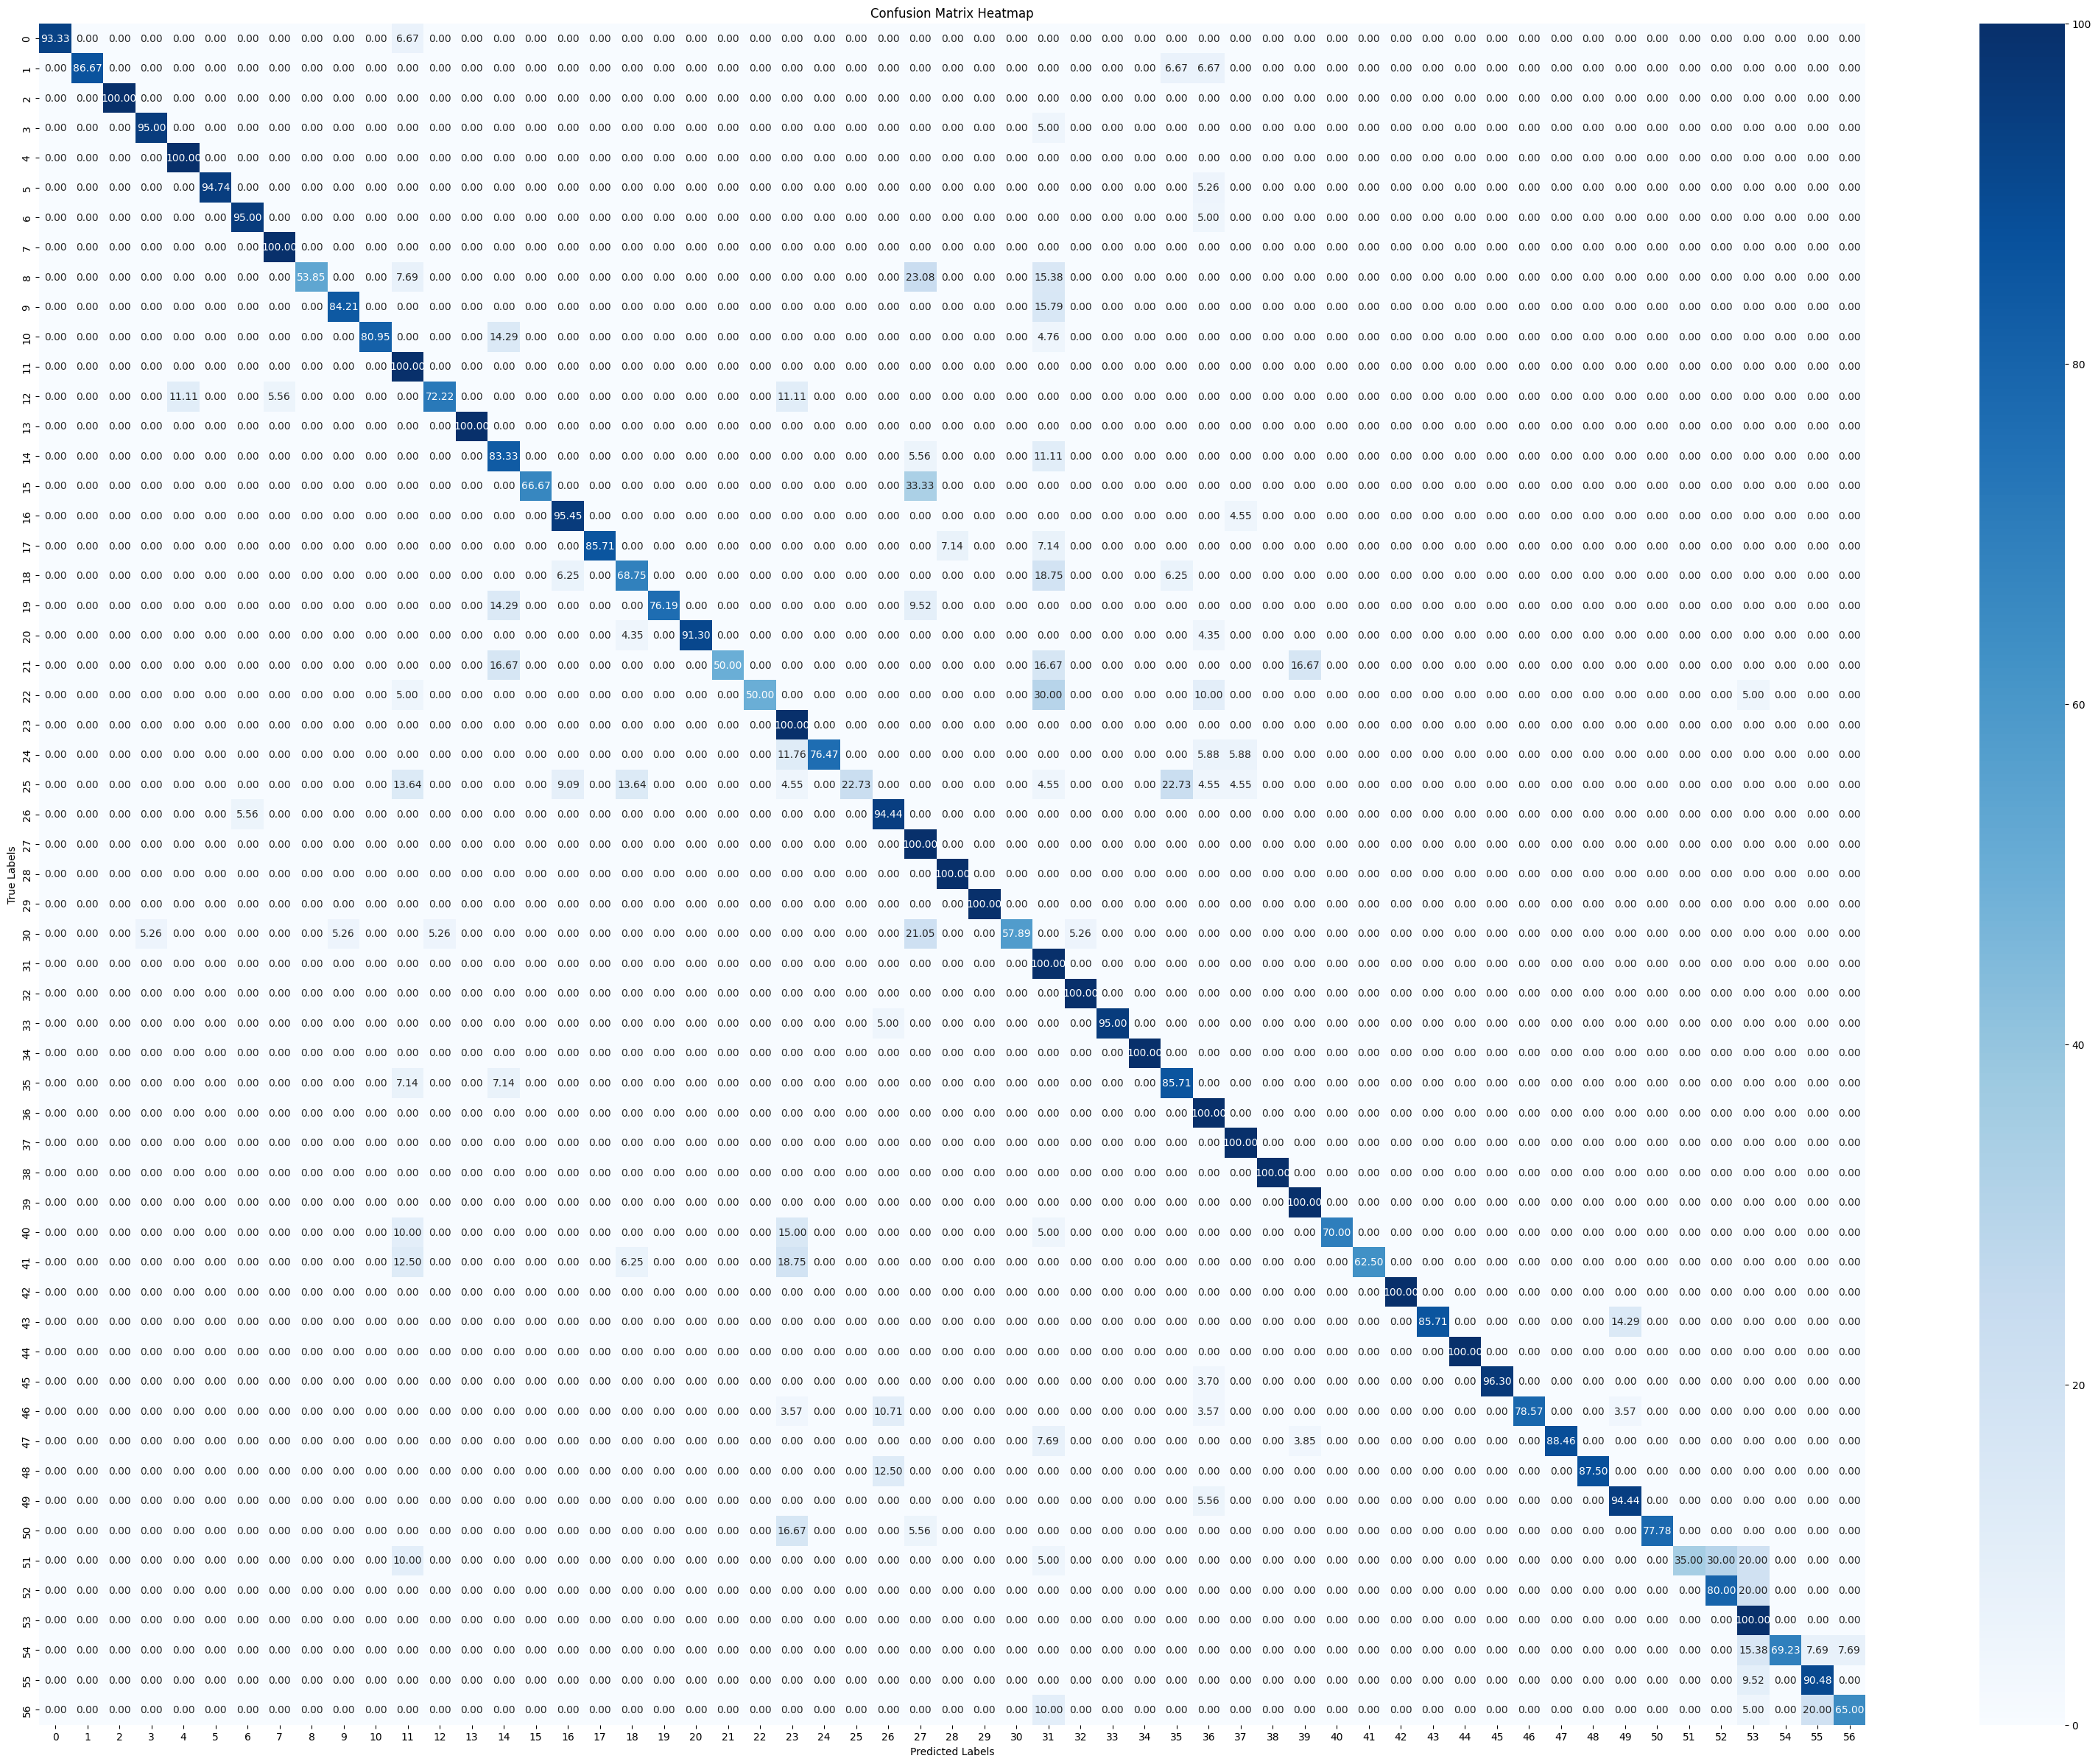

In [132]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Giả sử bạn đã có mô hình đã huấn luyện và test_loader là DataLoader cho tập test
# Chúng ta sẽ tạo danh sách để lưu trữ các nhãn dự đoán và nhãn thực tế
all_preds = []
all_labels = []

# Đánh giá mô hình trên tập test
with torch.no_grad():
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    for data, labels in train_dataset:
        data = data.unsqueeze(0)
        data = data.to(device)
        outputs = model(data)  # Dự đoán từ mô hình
        predicted_classes = torch.argmax(outputs, dim=1)  # Lấy nhãn có xác suất cao nhất
        all_preds.extend(predicted_classes.cpu().numpy())  # Thêm nhãn dự đoán vào danh sách
        all_labels.extend(labels.unsqueeze(0).numpy())  # Thêm nhãn thực tế vào danh sách
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Tính precision cho đa lớp
recall = recall_score(all_labels, all_preds, average='weighted')  # Tính recall cho đa lớp
f1 = f1_score(all_labels, all_preds, average='weighted')  # Tính F1-score cho đa lớp
confusion = confusion_matrix(all_labels, all_preds)  # Tính confusion matrix
cm_percentage = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] * 100

# In ra các kết quả đánh giá
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
# Tạo heatmap từ confusion matrix
plt.figure(figsize=(40, 30))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels), cbar=True)# Thêm các thông tin vào biểu đồ
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Hiển thị heatmap
plt.show()